In [1]:
import functools

import ase
from ase.visualize import view

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn
import optax
from clu import metrics

import matplotlib.pyplot as plt

from molnet.data import input_pipeline_online
from molnet.models import create_model
from molnet import train_state
from molnet import loss

from configs import attention_unet
from configs import root_dirs

from typing import Any, Dict, Tuple, Callable

2024-12-10 12:31:13.340175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
config = attention_unet.get_config()
config.batch_size = 4
config.interpolate_input_z = None
config.z_cutoff = 1.0
#config.train_molecules = (0, 80000)
#config.val_molecules = (80000, 100000)
config.train_molecules = (0, 50000)
config.val_molecules = (50000, 60000)
config.root_dir = root_dirs.get_root_dir("afms")

@flax.struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output("loss") # type: ignore

In [3]:
ds = input_pipeline_online.get_datasets(config)
rng = jax.random.PRNGKey(0)
init_rng, rng = jax.random.split(rng)

model = create_model(config.model)
dummy_input = next(ds['train'])
print(f"input shape: {dummy_input['images'].shape}")
print(f"atom map shape: {dummy_input['atom_map'].shape}")
variables = model.init(init_rng, dummy_input["images"], training=False)
params = variables["params"]
batch_stats = variables["batch_stats"]

loss_fn = loss.get_loss_function(config.loss_fn)
tx = optax.adam(learning_rate=3e-4)

2024-12-10 12:31:28.866462: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 10169466755920460416
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSna

input shape: (4, 128, 128, 20, 1)
atom map shape: (4, 128, 128, 10, 5)


In [4]:
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=tx,
    best_params=params,
    step_for_best_params=0,
    metrics_for_best_params={},
)

In [13]:
@functools.partial(jax.jit, static_argnums=(2,))
def train_step(
    state: train_state.TrainState,
    batch: Dict[str, Any],
    loss_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
) -> Tuple[train_state.TrainState, metrics.Collection]:
    """Train step."""

    def loss_wrapper(params):
        preds, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch["images"][..., -10:, :],
            training=True,
            mutable='batch_stats',
        )
        total_loss = loss_fn(
            preds,
            batch["atom_map"]
        )
        #mean_loss = jnp.mean(total_loss)

        return total_loss, (preds, updates)

    # Compute loss and gradients
    grad_fn = jax.value_and_grad(loss_wrapper, has_aux=True)
    (batch_loss, (_, updates)), grads = grad_fn(state.params)

    batch_metrics = Metrics.single_from_model_output(
        loss=batch_loss,
    )

    # Update parameters
    new_state = state.apply_gradients(
        grads=grads,
        batch_stats=updates["batch_stats"]
    )

    return new_state, batch_metrics


In [14]:
@functools.partial(jax.jit)
def pred_batch(
    state: train_state.TrainState,
    batch: Dict[str, Any],
) -> jnp.ndarray:
    preds = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        batch["images"][..., -10:, :],
        training=False,
    )
    return preds

In [15]:
for i in range(4000):
    batch = next(ds['train'])
    state, metrics = train_step(state, batch, loss_fn)
    if i % 10 == 0:
        print(f"Step {i}: {metrics.loss}")


Step 0: Metric.from_output.<locals>.FromOutput(total=Array(0.88053983, dtype=float32), count=Array(1, dtype=int32))
Step 10: Metric.from_output.<locals>.FromOutput(total=Array(0.05521517, dtype=float32), count=Array(1, dtype=int32))
Step 20: Metric.from_output.<locals>.FromOutput(total=Array(0.02219109, dtype=float32), count=Array(1, dtype=int32))
Step 30: Metric.from_output.<locals>.FromOutput(total=Array(0.05259004, dtype=float32), count=Array(1, dtype=int32))
Step 40: Metric.from_output.<locals>.FromOutput(total=Array(0.02157908, dtype=float32), count=Array(1, dtype=int32))
Step 50: Metric.from_output.<locals>.FromOutput(total=Array(0.02275343, dtype=float32), count=Array(1, dtype=int32))
Step 60: Metric.from_output.<locals>.FromOutput(total=Array(0.01382998, dtype=float32), count=Array(1, dtype=int32))
Step 70: Metric.from_output.<locals>.FromOutput(total=Array(0.01796122, dtype=float32), count=Array(1, dtype=int32))
Step 80: Metric.from_output.<locals>.FromOutput(total=Array(0.026

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8507679745870157114
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6956205353016170814
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

Step 1270: Metric.from_output.<locals>.FromOutput(total=Array(0.01671176, dtype=float32), count=Array(1, dtype=int32))
Step 1280: Metric.from_output.<locals>.FromOutput(total=Array(0.01323223, dtype=float32), count=Array(1, dtype=int32))
Step 1290: Metric.from_output.<locals>.FromOutput(total=Array(0.00957185, dtype=float32), count=Array(1, dtype=int32))
Step 1300: Metric.from_output.<locals>.FromOutput(total=Array(0.01140558, dtype=float32), count=Array(1, dtype=int32))
Step 1310: Metric.from_output.<locals>.FromOutput(total=Array(0.00913595, dtype=float32), count=Array(1, dtype=int32))
Step 1320: Metric.from_output.<locals>.FromOutput(total=Array(0.01024088, dtype=float32), count=Array(1, dtype=int32))
Step 1330: Metric.from_output.<locals>.FromOutput(total=Array(0.02577553, dtype=float32), count=Array(1, dtype=int32))
Step 1340: Metric.from_output.<locals>.FromOutput(total=Array(0.03004318, dtype=float32), count=Array(1, dtype=int32))
Step 1350: Metric.from_output.<locals>.FromOutpu

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8930936334720574893
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4100370931828718731
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

Step 2810: Metric.from_output.<locals>.FromOutput(total=Array(0.00671651, dtype=float32), count=Array(1, dtype=int32))
Step 2820: Metric.from_output.<locals>.FromOutput(total=Array(0.01547184, dtype=float32), count=Array(1, dtype=int32))
Step 2830: Metric.from_output.<locals>.FromOutput(total=Array(0.00603898, dtype=float32), count=Array(1, dtype=int32))
Step 2840: Metric.from_output.<locals>.FromOutput(total=Array(0.00647162, dtype=float32), count=Array(1, dtype=int32))
Step 2850: Metric.from_output.<locals>.FromOutput(total=Array(0.0264607, dtype=float32), count=Array(1, dtype=int32))
Step 2860: Metric.from_output.<locals>.FromOutput(total=Array(0.00595806, dtype=float32), count=Array(1, dtype=int32))
Step 2870: Metric.from_output.<locals>.FromOutput(total=Array(0.01465639, dtype=float32), count=Array(1, dtype=int32))
Step 2880: Metric.from_output.<locals>.FromOutput(total=Array(0.0120438, dtype=float32), count=Array(1, dtype=int32))
Step 2890: Metric.from_output.<locals>.FromOutput(

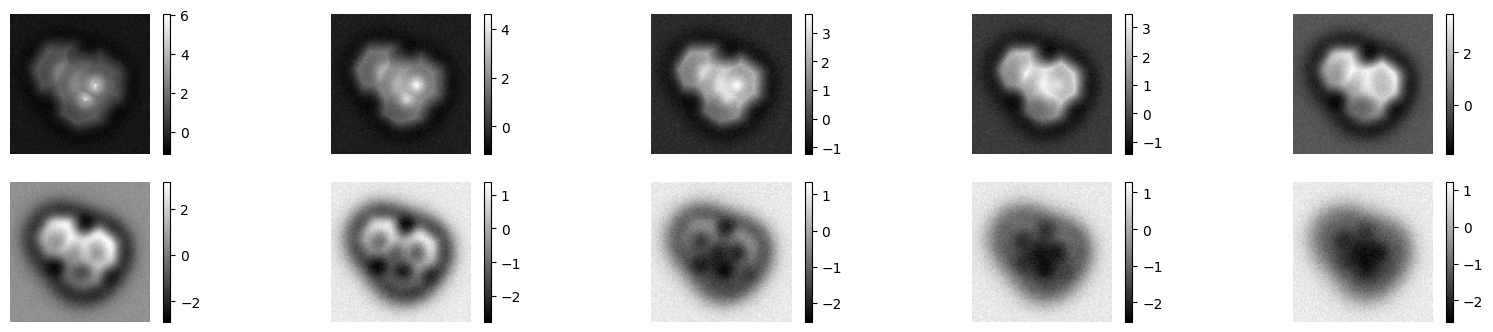

In [36]:
batch = next(ds['val'])
y = pred_batch(state, batch)
idx = 1
y0 = y[idx]
ref = batch["atom_map"][idx]
x0 = batch["images"][idx]


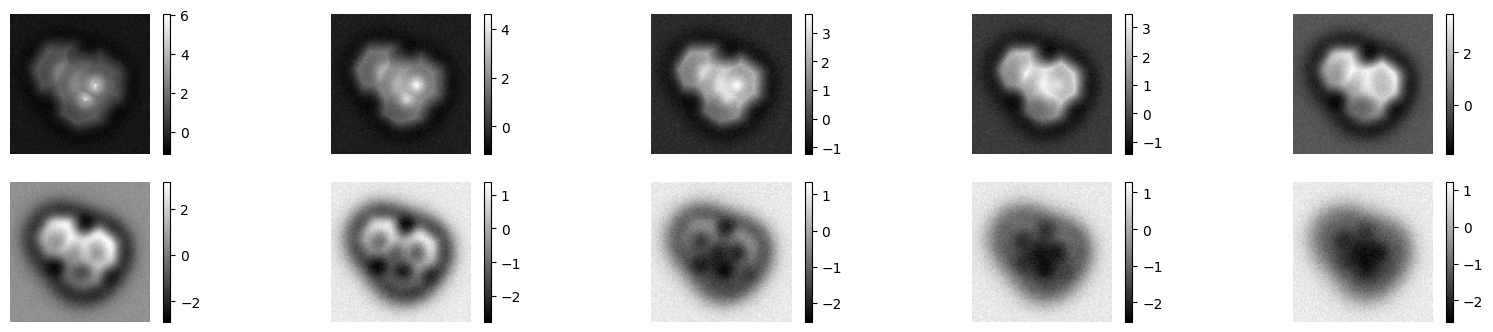

In [37]:
fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    im = ax.imshow(x0[..., -1-i, 0], cmap='gray', origin='lower')
    plt.colorbar(im)

    ax.axis('off')


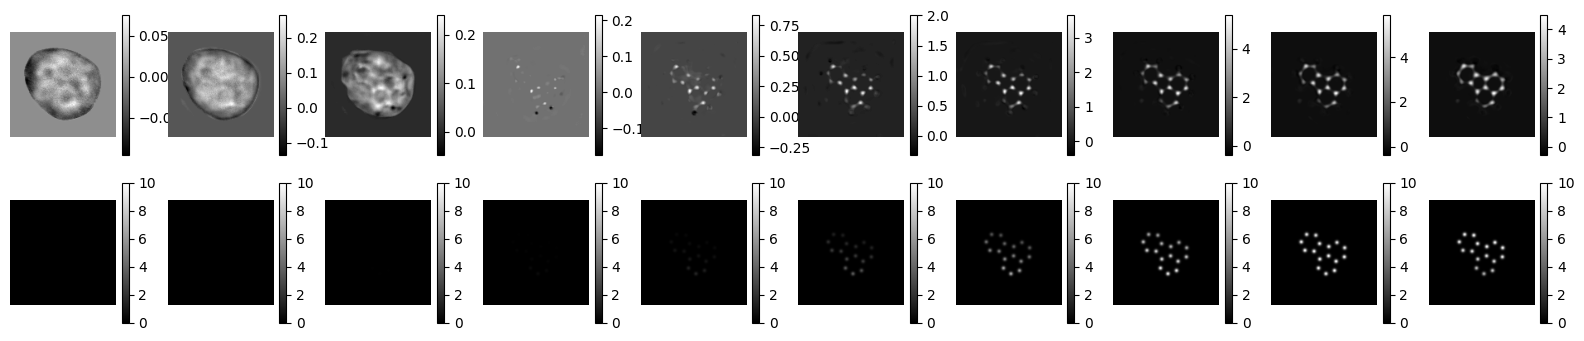

In [40]:
channel = 1

fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    im = ax.imshow(y0[..., i, channel], cmap='gray', origin='lower',)
    plt.colorbar(im)
    ax.axis('off')

    ax = plt.subplot(2, 10, i+11)
    im = ax.imshow(ref[..., i, channel], cmap='gray', origin='lower', vmin=0, vmax=10)
    plt.colorbar(im)
    ax.axis('off')



In [ ]:
xyz = batch["xyz"][0]
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1])
view(mol)

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>